# Sentiment Analysis

This notebook describes sentiment analysis of a corpus with NLTK. It's part of the [The Art of Literary Text Analysis](ArtOfLiteraryTextAnalysis.ipynb) (and assumes that you've already worked through previous notebooks – see the table of contents). In this notebook we'll look in particular at

* creating a sonnets corpus
* using a plain text corpus reader
* introducing sentiment analysis
* doing sentiment analysis with word lists
* doing sentiment analysis with WordNet
* doing sentiment analysis of Shakespeare's sonnets
* outputting HTML

## Create a Sonnets Corpus

We're going to start by downloading [Shakespeare's sonnets from Gutenberg](http://www.gutenberg.org/cache/epub/1041/pg1041.txt). The ususal provisos apply regarding web-based URLs and particularly ones from Gutenberg: content can be inaccessible (moved, blocked, etc.), and it's best to limit the number of times you make the actual request, so we'll isolate the reading in its own cell.

In [25]:
import urllib.request
sonnetsUrl = "http://www.gutenberg.org/cache/epub/1041/pg1041.txt"
sonnetsString = urllib.request.urlopen(sonnetsUrl).read().decode()
len(sonnetsString) # let's make sure we have a lot of characters

122774

A Gutenberg text includes additiona elements like a header and footer that we don't want to include in our anaysis, so just as we did in [Getting Texts](GettingTexts.ipynb), we need to isolate the main body of text. To do that we can [look more closely at the text](http://www.gutenberg.org/cache/epub/1041/pg1041.txt) and see that the first sonnet (and each of the subsequent ones) starts with a roman numeral ("I") and that the text ends with "End of Project Gutenberg's", so let's create a filtered sonnets string by finding the locations of our two marker strings and keeping only the text in between.

In [26]:
filteredSonnetsStart = sonnetsString.find("  I\r\n") # title of first sonnet
filteredSonnetsEnd = sonnetsString.find("End of Project Gutenberg's") # end of sonnets
filteredSonnetsString = sonnetsString[filteredSonnetsStart:filteredSonnetsEnd].rstrip() # strip spaces from the end (right)
print(filteredSonnetsString[:75] + ' … ' + filteredSonnetsString[-75:])

  I

  From fairest creatures we desire increase,
  That thereby beauty' … d this by that I prove,
    Love's fire heats water, water cools not love.


In looking at the sonnets we see that they all follow the same format of a roman numeral and then a block of text. That's a pattern that's fairly easy to define with regular expressions, we can look for the following:

* two spaces (all the text is indented): "  "
* one or more uppercase characters that represent the roman numerals (I, IV, XI, etc.) ```[A-Z]+```
  * we can do this by using a character range that says any character between A and Z or ```[A-Z]+```
  * alternatively, we could enumerage a list of relevant characters ```[IVXLC]+```
  * the plus sign at the end specifies that we should match one or more instances of what preceeds
* two Windows-style carriage returns and newlines: "\r\n\r\n"

Putting that together we get: ```"  [A-Z]+\r\n\r\n"``` and we can use this to split our filtered sonnets into chunks based on the roman numeral separators. This is a bit like splitting the cells in a row of of comma-separated values, except that instead of knowing exactly which delimeter character to use (like a comma), we're defining a flexible delimeter that can contain types of characters. We use [re.split()](https://docs.python.org/3/library/re.html#re.split) to split the original string into a list of strings (one for each sonnet).

In [27]:
import re
sonnetsList = re.split("  [A-Z]+\r\n\r\n", filteredSonnetsString)
print(sonnetsList[1]) # sonnetList[0] is empty (the text before the first roman numeral), let's look at sonnet I

  From fairest creatures we desire increase,
  That thereby beauty's rose might never die,
  But as the riper should by time decease,
  His tender heir might bear his memory:
  But thou contracted to thine own bright eyes,
  Feed'st thy light's flame with self-substantial fuel,
  Making a famine where abundance lies,
  Thy self thy foe, to thy sweet self too cruel:
  Thou that art now the world's fresh ornament,
  And only herald to the gaudy spring,
  Within thine own bud buriest thy content,
  And tender churl mak'st waste in niggarding:
    Pity the world, or else this glutton be,
    To eat the world's due, by the grave and thee.




Now that we have a list of sonnets, let's write them to a file in case we want to load them later.

Just as we did with [Getting Texts](GettingTexts.ipynb), we'll create a directory (if it doesn't exist already).

In [28]:
import os
sonnetsPath = 'sonnets' # this subdirectory will be relative to the current notebook
if not os.path.exists(sonnetsPath):
    os.makedirs(sonnetsPath)

Let's enumerate through each sonnet (we [enumerate](https://docs.python.org/3/library/functions.html#enumerate) so that we can get the index of each item in our list), and for each sonnet we'll write it into a new file. We won't use the roman numerals for the file names, but we'll use [str.zfill()](https://docs.python.org/3/library/stdtypes.html?highlight=zfill#str.zfill) to get zero-padded strings.

In [29]:
print(str(1).zfill(3)) # convert the number 1 to a string and prepend zeros as needed to get three characters
print(str(150).zfill(3)) # convert the number 150 to a string and prepend zeros as needed to get three characters

001
150


In [30]:
for index, sonnet in enumerate(sonnetsList): # loop through our list as enumeration to get index
    if len(sonnet.strip()) > 0: # make sure we have text, not empty after stripping out whitespace
        filename = str(index).zfill(3)+".txt" # create filename from index
        pathname = os.path.join(sonnetsPath, filename) # directory name and filenamee
        f = open(pathname, "w")
        f.write(sonnet.rstrip()) # write out our sonnet into the file (removing whitespace at the end/right)
        f.close()

If we navigate to the directory where our notebook is we should now have a subdirectory called "sonnets" with 154 text files, one per sonnet.

## Plain Text Corpus Reader

We've already seen how we can work with many files in a directory using a corpus reader. For instance, we can look at the Gutenberg corpus and ask how many files there are.

In [31]:
import nltk
print(nltk.corpus.gutenberg.fileids())

['austen-emma.txt', 'austen-persuasion.txt', 'austen-sense.txt', 'bible-kjv.txt', 'blake-poems.txt', 'bryant-stories.txt', 'burgess-busterbrown.txt', 'carroll-alice.txt', 'chesterton-ball.txt', 'chesterton-brown.txt', 'chesterton-thursday.txt', 'edgeworth-parents.txt', 'melville-moby_dick.txt', 'milton-paradise.txt', 'shakespeare-caesar.txt', 'shakespeare-hamlet.txt', 'shakespeare-macbeth.txt', 'whitman-leaves.txt']


We can't do the same thing directly with our sonnetsPath directory because it's not a corpus.

```python
sonnetsPath.fileids() # this won't work, it's not a corpus
nltk.corpus.sonnetsPath.fileids() # neither is this (nltk.corpus doesn't have a sonnetsPath module)```

What we can do is to create a new corpus using the [PlaintextCorpusReader](http://www.nltk.org/api/nltk.corpus.reader.html#nltk.corpus.reader.plaintext.PlaintextCorpusReader), giving it the path of our directory and telling it too consider all texts.

In [32]:
from nltk.corpus import PlaintextCorpusReader
sonnetsCorpus = PlaintextCorpusReader(sonnetsPath, '.*txt')
len(sonnetsCorpus.fileids())

154

Let's now see how many words are in our corpus.

In [33]:
def corpus_summary(corpus):
    print("this corpus has")
    print("  ", '{:,}'.format(len(sonnetsCorpus.fileids())), "files")
    tokens = corpus.words() # this includes *all* words in all files
    print("  ", '{:,}'.format(len(tokens)), "tokens")
    words = [word for word in tokens if word[0].isalpha()]
    print("  ", '{:,}'.format(len(tokens)), "words")
    print("  ", '{:,}'.format(len(set(tokens))), "unique word types")

corpus_summary(sonnetsCorpus)

this corpus has
   154 files
   21,717 tokens
   21,717 words
   3,358 unique word types


## Introduction to Sentiment Analysis

[Sentiment analysis](http://en.wikipedia.org/wiki/Sentiment_analysis) is a general term used in text mining to refer to the process of trying to automatically determine the mood or opinion of texts. For example, we might be interested in reading through a large quantity of tweets on a particular topic (issue, product, person, event, etc.) to determine if they are generally positive or negative. This is a typical task in determining polarity, or the general orientation of each text toward to poles. The poles can be positive or negative or any other binary pair (happy/sad, calm/excited, etc.).

There are several ways of doing sentiment analysis and one of the most common ways is to use training sets to develop models of texts that can then be used to read and classify new texts that aren't part of the training set. For instance, NLTK has a corpus of movie reviews that have been classified by hand as either positive or negative, these could be used to classify new movie reviews.

There's a high-level Python module called [TextBlob](https://textblob.readthedocs.org/en/latest/index.html) that makes use of the movie reviews corpus and that is very easy to use. Once [installed](https://textblob.readthedocs.org/en/latest/install.html), you can do something like this:

```python
from textblob import TextBlob
text = "Textblob is amazingly simple to use. What great fun!"
testimonial = TextBlob(text) # any string (such as our sonnets)
testimonial.sentiment.polarity # this produces a positive value of 0.39166666666666666```

The strength of this approach depends in large part on the training set and its relevance to the corpus you want to analyze. Analyzing Shakespeare's sonnets based on movie reviews may not be quite ideal. As importantly, it can be tricky to understand and tweak a model once it's been loaded into a classifier (such as [a Naive Bayes Classifier](http://www.nltk.org/api/nltk.classify.html#nltk.classify.naivebayes.NaiveBayesClassifier)).

In any case, classifiers depend on relevant training sets, and we don't always have those. We can take a simpler approach and perform sentiment analysis based on word lists.

## Word List Sentiment Analysis

In some ways, sentiment analysis can be very simple: read each text, look for words that we know are positive or negative, and assign a value to each one. Let's start by defining an absurdly short and incomplete list of sentiment words, with values ranging from -1 (most negative) to 1 (most positive).

In [34]:
short_sentiments = {
    "pos": {
        "love": 1,
        "like": .5
    },
    "neg": {
        "hate": -1,
        "dislike": -.5
    }
}

Now we can go through our corpus and read every text to find out how many times each of our sentiment words appears. We'll multiply the count by the value for that word.

In [35]:
documents = {} # keep track of values for each document
for fileid in sonnetsCorpus.fileids():
    text = sonnetsCorpus.raw(fileid).lower() # read each text and convert to lower case
    tokens = nltk.word_tokenize(text) # tokenize
    score = 0 # keep track of the score fo this document
    for polarity, words_dict in short_sentiments.items(): # look at our sentiments dictionary
        for word, value in words_dict.items(): # go through each word in the list
            score += tokens.count(word) * value # count the occurences and multiply by value (often zero)
    documents[fileid] = score # assign the score

Let's use our fileid, score dictionary to create a FreqDist list and retrieve the most positive sonnet.

In [36]:
valuesFreqs = nltk.FreqDist(documents) # calcuate the frequencies
mostFrequentFileid = valuesFreqs.max() # most positive (top value) sonnet
print(sonnetsCorpus.raw(mostFrequentFileid))

  Take all my loves, my love, yea take them all;
  What hast thou then more than thou hadst before?
  No love, my love, that thou mayst true love call;
  All mine was thine, before thou hadst this more.
  Then, if for my love, thou my love receivest,
  I cannot blame thee, for my love thou usest;
  But yet be blam'd, if thou thy self deceivest
  By wilful taste of what thyself refusest.
  I do forgive thy robbery, gentle thief,
  Although thou steal thee all my poverty:
  And yet, love knows it is a greater grief
  To bear love's wrong, than hate's known injury.
    Lascivious grace, in whom all ill well shows,
    Kill me with spites yet we must not be foes.


This word list approach has the great merit of being fairly easy to understand, we know which words we're dealing with (and can easily modify the list) and we can see exactly how it's working. The major weakness, of course, is that we need to define the word sentiment values in advance, which means that we need to know which sentiment words are in the corpus (or use a generic list).

An alternative is to call on the sentiment values that are encoded in WordNet.

## Sentiment Analytsis with WordNet

WordNet includes a mechanism for determining the positive or negative value of a synset (if any values are defined). In the simplest case, we can ask for all of the sentiment values for a given word form.

In [37]:
from nltk.corpus import sentiwordnet as swn
for senti_synset in swn.senti_synsets('good'):
    print(senti_synset, senti_synset.synset.definition())

<good.n.01: PosScore=0.5 NegScore=0.0> benefit
<good.n.02: PosScore=0.875 NegScore=0.0> moral excellence or admirableness
<good.n.03: PosScore=0.625 NegScore=0.0> that which is pleasing or valuable or useful
<commodity.n.01: PosScore=0.0 NegScore=0.0> articles of commerce
<good.a.01: PosScore=0.75 NegScore=0.0> having desirable or positive qualities especially those suitable for a thing specified
<good.a.03: PosScore=1.0 NegScore=0.0> morally admirable
<well.r.01: PosScore=0.375 NegScore=0.0> (often used as a combining form) in a good or proper or satisfactory manner or to a high standard (`good' is a nonstandard dialectal variant for `well')
<thoroughly.r.02: PosScore=0.0 NegScore=0.0> completely and absolutely (`good' is sometimes used informally for `thoroughly')


As we can see, most meanings of "good" have a positive value, though some meanings are indicated as being neutral (_commodity.n.01_, _thoroughly.r.02_). Some meanings are more positive than others (such as _good.a.03_ "morally admirable").

If we can guess at the part of speech we can narrow our search. Here are the possible parts of speech:

* n: noun
* a: adjective
* v: verb
* r: adverb

In [38]:
for senti_synset in swn.senti_synsets('good', 'a'): # consider only adjectives
    print(senti_synset, senti_synset.synset.definition())

<good.a.01: PosScore=0.75 NegScore=0.0> having desirable or positive qualities especially those suitable for a thing specified
<good.a.03: PosScore=1.0 NegScore=0.0> morally admirable


As we can see, some senti_synsets can be both positive and negative:

In [39]:
for senti_synset in swn.senti_synsets('wicked', 'a'): # consider only adjectives
    print(senti_synset, senti_synset.synset.definition()) # wicked can be positive or negative

<wicked.a.01: PosScore=0.25 NegScore=0.625> morally bad in principle or practice


We can combine NLTK's part of speech analysis with the sentiment analysis module. As a reminder, the default NLTK parts of speech output looks something like this.

In [40]:
text = "This is a good sentence."
tokens = nltk.word_tokenize(text)
tagged = nltk.pos_tag(tokens)
tagged

[('This', 'DT'),
 ('is', 'VBZ'),
 ('a', 'DT'),
 ('good', 'JJ'),
 ('sentence', 'NN'),
 ('.', '.')]

So we need a way of mapping the [Treebank](https://www.ling.upenn.edu/courses/Fall_2003/ling001/penn_treebank_pos.html) NLTK parts of speech to the WordNet ones.

For this function we'll demonstrate the use of an option argument. We can specify a variable name as being equal to something such that if we don't include a second argument to the function call, it defaults to the value we provide.

* treebank_to_wordnet_pos(treebank) # this form uses the default empty list []
* treebank_to_wordnet_pos(treebank, ["v"]) # this form specifies a second argument with a list

In [41]:
def treebank_to_wordnet_pos(treebank, skipWordNetPos=[]):
    if "NN" in treebank and "n" not in skipWordNetPos: # singular and plural nouns (NN, NNS)
        return "n"
    elif "JJ" in treebank and "a" not in skipWordNetPos: # adjectives including comparatives and superlatives (JJ, JJR, JJS)
        return "a" 
    elif "VB" in treebank and "v" not in skipWordNetPos: # verbs in various forms (VB, VBD, VBG, VBN, VBP, VBZ)
        return "v"
    elif "RB" in treebank and "r" not in skipWordNetPos: # adverbs including comparatives and superlatives (RB, RBR, RBS)
        return "r"
    # if we don't match any of these we implicitly return None

Let's try using our treebank_to_wordnet_pos() lookup function:

In [42]:
for word, treebank in tagged:
    wordnet_pos = treebank_to_wordnet_pos(treebank)
    if wordnet_pos: # only print matches
        print(word, wordnet_pos)

is v
good a
sentence n


And a variant where we use the ability to skip certain parts of speech (like "v" for verbs):

In [43]:
for word, treebank in tagged:
    wordnet_pos = treebank_to_wordnet_pos(treebank, ["v"])
    if wordnet_pos: # only print matches
        print(word, wordnet_pos)

good a
sentence n


Now let's look at the WordNet senti_synsets for each of our word, part of speech pairs:

In [44]:
for word, treebank in tagged:
    wordnet_pos = treebank_to_wordnet_pos(treebank, ["v"])
    if wordnet_pos: # only print matches
        print(word)
        for senti_synset in swn.senti_synsets(word, wordnet_pos):
            print("  ", senti_synset)

good
   <good.a.01: PosScore=0.75 NegScore=0.0>
   <good.a.03: PosScore=1.0 NegScore=0.0>
sentence
   <sentence.n.01: PosScore=0.0 NegScore=0.0>
   <conviction.n.02: PosScore=0.0 NegScore=0.0>
   <prison_term.n.01: PosScore=0.0 NegScore=0.0>


Here we have to make a decision: do we take into consideration every senti_synset or just the first (and most common) meaning? When processing a larger corpus we have no way of knowning which meaning is correct. For the sake of simplicity, let's just consider the first meaning.

In [45]:
def get_sentiment_score_from_tagged(token, treebank, skipWordNetPos=[]):
    wordnet_pos = treebank_to_wordnet_pos(treebank, skipWordNetPos)
    if wordnet_pos: # only print matches
        senti_synsets = list(swn.senti_synsets(token, wordnet_pos))
        if senti_synsets:
            return senti_synsets[0].pos_score() - senti_synsets[0].neg_score()

And trying it out with our simple example tagged set.

In [46]:
for word, treebank in tagged:
    score = get_sentiment_score_from_tagged(word, treebank, ["v"])
    if score:
        print(word, score)

good 0.75


So we're now able to get a sentiment score for any tagged word (that is defined by WordNet). Let's back up a further step and create a function that processes a set of tokens and returns three components:

1. an aggregate sentiment score for the tokens
1. a list of positive words
1. a list of negative words

In [47]:
def get_sentiment_data_from_tokens(tokens, skipWordNetPos=[]):
    tagged = nltk.pos_tag(tokens)
    positives = []
    negatives = []
    tokens_score = 0
    for word, treebank in tagged:
        score = get_sentiment_score_from_tagged(word, treebank, skipWordNetPos)
        if score:
            tokens_score += score
            if score > 0:
                positives.append(word.lower())
            else:
                negatives.append(word.lower())
    return tokens_score, set(positives), set(negatives)

In [48]:
get_sentiment_data_from_tokens(tokens)

(0.875, {'good', 'is'}, set())

## Sentiment Analysis of Shakespeare's Sonnets

Now that we have functions to assign sentiment values and collect positive and negative words for any set of tokens, we can proceed with creating a last function that returns a dictionary with values for each document along with an aggregate list of positive and negative words.

In [49]:
def get_sentiments_data_from_corpus(corpus, skipWordNetPos=[]):
    documents = {}
    all_positives = []
    all_negatives = []
    for fileid in corpus.fileids():
        tokens = corpus.words(fileid)
        score, positives, negatives = get_sentiment_data_from_tokens(tokens, skipWordNetPos)
        documents[fileid] = score
        [all_positives.append(positive) for positive in positives]
        [all_negatives.append(negative) for negative in negatives]
    return documents, set(all_positives), set(all_negatives)

Ok, so now let's pass in our corpus and see what we get!

In [50]:
sonnetsSentimentValues, sonnetsPositives, sonnetsNegatives = get_sentiments_data_from_corpus(sonnetsCorpus)

Once again one of the easiest ways of working with the sentiment values is to create a FreqDist object.

In [51]:
sonnetsSentimentFreqs = nltk.FreqDist(sonnetsSentimentValues)

Now we can see what kind of sentiment values we have, by plotting, for instance:

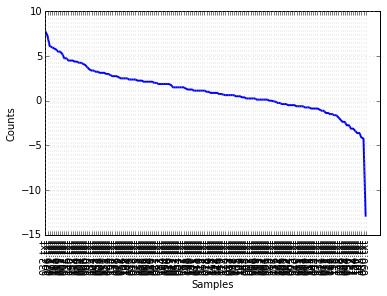

In [52]:
%matplotlib inline
sonnetsSentimentFreqs.plot()

Even if the x (bottom) axis is illegible, we can see that there are both positive and negatively scored sonnets. Can we determine an average? Sure, let's use numpty.mean() on the list of values.

In [53]:
import numpy
numpy.mean([val for doc, val in sonnetsSentimentFreqs.items()])

1.0786493506493506

This suggests that on average the sonnets are more positive than negative.

## Outputting HTML

We might want to show the most positive and negative sonnets, but to make it even more useful we'd want to show which words are positive and which are negative. Let's create a function to get HTML for any of our documents.

In [54]:
def get_html_for_sentiment_data(text, positives, negatives):
    # the regular expression combines all of the positive and negative words for a search, e.g. (love|like)
    # it then surrounds the word found in parentheses with styling, green for positive, red for negative
    if len(positives) > 0:
        text = re.sub(r'\b(' + '|'.join(positives) + r')\b', r'<span style="color: green">\1</span>', text)
    if len(negatives) > 0:
        text = re.sub(r'\b(' + '|'.join(negatives) + r')\b', r'<span style="color: red">\1</span>', text)
    return text

We can use this to generate an HTML snippet.

In [55]:
fileid = sonnetsSentimentFreqs.max() # most positive
text = sonnetsCorpus.raw(fileid)
html = get_html_for_sentiment_data(text, sonnetsPositives, sonnetsNegatives)

We have the HTML above, but it appears as code, so we need to use iPython's facilities for embedding HTML.

In [56]:
from IPython.display import HTML
HTML("<h2>" + fileid + "</h2><pre>" + html + "</pre>")

And now the most negative sonnet.

In [57]:
fileid = sonnetsSentimentFreqs.most_common()[-1][0] # most negative (fileid of the last element in the most common list)
text = sonnetsCorpus.raw(fileid)
html = get_html_for_sentiment_data(text, sonnetsPositives, sonnetsNegatives)
HTML("<h2>" + fileid + "</h2><pre>" + html + "</pre>")

There's a lot that we could look at and question here, and we should do so, but there's also some intriguing aspects, particularly for such an automated process.

For the sake of convenience, here are the main functions that we defined for sentiment analysis of a corpus:

```python
import nltk
from nltk.corpus import sentiwordnet as swn

def get_sentiments_data_from_corpus(corpus, skipWordNetPos=[]):
    documents = {}
    all_positives = []
    all_negatives = []
    for fileid in corpus.fileids():
        tokens = corpus.words(fileid)
        score, positives, negatives = get_sentiment_data_from_tokens(tokens, skipWordNetPos)
        documents[fileid] = score
        [all_positives.append(positive) for positive in positives]
        [all_negatives.append(negative) for negative in negatives]
    return documents, set(all_positives), set(all_negatives)

def get_sentiment_data_from_tokens(tokens, skipWordNetPos=[]):
    tagged = nltk.pos_tag(tokens)
    positives = []
    negatives = []
    tokens_score = 0
    for word, treebank in tagged:
        score = get_sentiment_score_from_tagged(word, treebank, skipWordNetPos)
        if score:
            tokens_score += score
            if score > 0:
                positives.append(word.lower())
            else:
                negatives.append(word.lower())
    return tokens_score, set(positives), set(negatives)

def get_sentiment_score_from_tagged(token, treebank, skipWordNetPos=[]):
    wordnet_pos = treebank_to_wordnet_pos(treebank, skipWordNetPos)
    if wordnet_pos: # only print matches
        senti_synsets = list(swn.senti_synsets(token, wordnet_pos))
        if senti_synsets:
            return senti_synsets[0].pos_score() - senti_synsets[0].neg_score()

def treebank_to_wordnet_pos(treebank, skipWordNetPos=[]):
    if "NN" in treebank and "n" not in skipWordNetPos: # singular and plural nouns (NN, NNS)
        return "n"
    elif "JJ" in treebank and "a" not in skipWordNetPos: # adjectives (JJ, JJR, JJS)
        return "a" 
    elif "VB" in treebank and "v" not in skipWordNetPos: # verbs (VB, VBD, VBG, VBN, VBP, VBZ)
        return "v"
    elif "RB" in treebank and "r" not in skipWordNetPos: # adverbs (RB, RBR, RBS)
        return "r"
    # if we don't match any of these we implicitly return None```

## Next Steps

Try these tasks:

* experiment with different values for skipWordNetPos – which combination seems to give the best results?
* can you set a threshold of positive and negative values to improve results?
* can you add your own stopword list to the function signatures and have those words skipped when looking for sentiment?

---
[CC BY-SA](https://creativecommons.org/licenses/by-sa/4.0/) From [The Art of Literary Text Analysis](ArtOfLiteraryTextAnalysis.ipynb) by [Stéfan Sinclair](http://stefansinclair.name) &amp; [Geoffrey Rockwell](http://geoffreyrockwell.com)<br >Created March 9, 2015 and last modified December 9, 2015 (Jupyter 4)